In [62]:
from time import time
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
from skimage.morphology import label
from scipy.ndimage import measurements
from copy import deepcopy as dcopy
import numba as nb
import itertools


In [63]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([[i,j] for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[10:18]))))

### 'Pent-up' Frustration

Place as many distinct pentominoes as you want into an 8-by-8 grid, in such a
way that the placement is “tight” — i.e., no piece(s) can freely slide around
within the grid.
The score for a given placement is the
sum of the square roots of the areas of
the empty regions
in the grid.
What is the largest score you can obtain?
This month, when you send in your entry, please send in your grid. Please use
the
standard
notation
, — i.e. F,
I, L, N, P, T, U, V, W, X, Y, Z — and use “.” to denote empty spaces. (So the
top row in the valid placement example would be “…Z..LL”)

<img src='https://www.janestreet.com/puzzles/20181101_pent-up.png' width =300>

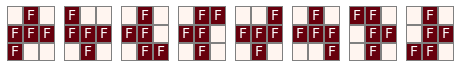

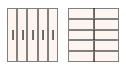

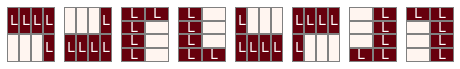

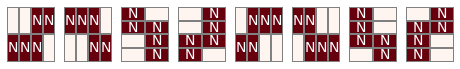

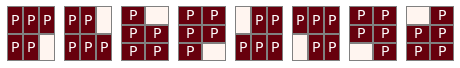

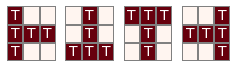

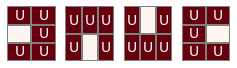

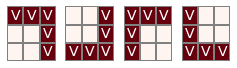

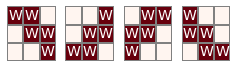

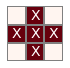

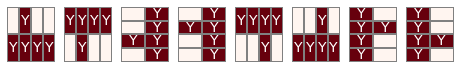

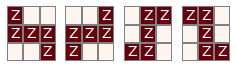

In [88]:
def create_rotations(test_grid):
    rotations = [test_grid]
    for i in range(4):
        a = np.rot90(test_grid,i)
        b = np.flip(np.rot90(test_grid,i),0)
        if all(not np.array_equal(a,x) for x in rotations):
            rotations.append(a)
        if all(not np.array_equal(b,x) for x in rotations):
            rotations.append(b)
        
    return(rotations)


shape_list = [[np.array([[' ', 'F', ' '],
                       ['F', 'F', 'F'],
                       ['F', ' ', ' ']], dtype=object),"F"],
             [np.array([['I', 'I', 'I', 'I', 'I']], dtype=object),"I"],            
             [np.array([['L', 'L', 'L', 'L'],
                       [' ', ' ', ' ', 'L']], dtype=object),"L"],
             [np.array([[' ', ' ', 'N', 'N'],
                       ['N', 'N', 'N', ' ']], dtype=object),"N"],
             [np.array([['P', 'P', 'P'],
                       ['P', 'P', ' ']], dtype=object),"P"],
             [np.array([['T', ' ', ' '],
                       ['T', 'T', 'T'],
                       ['T', ' ', ' ']], dtype=object),"T"],
             [np.array([['U', 'U'],
                       [' ', 'U'],
                       ['U', 'U']], dtype=object),"U"],
             [np.array([['V', 'V', 'V'],
                       [' ', ' ', 'V'],
                       [' ', ' ', 'V']], dtype=object),"V"],
             [np.array([['W', 'W', ' '],
                       [' ', 'W', 'W'],
                       [' ', ' ', 'W']], dtype=object),"W"],
             [np.array([[' ', 'X', ' '],
                       ['X', 'X', 'X'],
                       [' ', 'X', ' ']], dtype=object),"X"],
             [np.array([[' ', 'Y', ' ', ' '],
                       ['Y', 'Y', 'Y', 'Y']], dtype=object),"Y"],
             [np.array([['Z', ' ', ' '],
                       ['Z', 'Z', 'Z'],
                       [' ', ' ', 'Z']], dtype=object),"Z"]]

available_shapes = []
for s in shape_list:
    shape = create_rotations(s[0])
    l = len(shape)
    fig,axs = plt.subplots(1,l,figsize =(l,1))
    count =0
    for i in shape:
        if l > 1 :
            axs[count] = sns.heatmap(i != ' ',annot=i,cbar=False,cmap="Reds",fmt="",linewidths=1,annot_kws={"size":14},linecolor='grey',ax = axs[count])
            axs[count].axis("off")
            count +=1
        else:
            axs = sns.heatmap(i != ' ',annot=i,cbar=False,cmap="Reds",fmt="",linewidths=1,annot_kws={"size":14},linecolor='grey')
            axs.axis("off")

In [200]:
shape_list = [[np.array([[' ', 'F', ' '],
                       ['F', 'F', 'F'],
                       ['F', ' ', ' ']], dtype=object),"F"],
             [np.array([['I', 'I', 'I', 'I', 'I']], dtype=object),"I"],            
             [np.array([['L', 'L', 'L', 'L'],
                       [' ', ' ', ' ', 'L']], dtype=object),"L"],
             [np.array([[' ', ' ', 'N', 'N'],
                       ['N', 'N', 'N', ' ']], dtype=object),"N"],
             [np.array([['P', 'P', 'P'],
                       ['P', 'P', ' ']], dtype=object),"P"],
             [np.array([['T', ' ', ' '],
                       ['T', 'T', 'T'],
                       ['T', ' ', ' ']], dtype=object),"T"],
             [np.array([['U', 'U'],
                       [' ', 'U'],
                       ['U', 'U']], dtype=object),"U"],
             [np.array([['V', 'V', 'V'],
                       [' ', ' ', 'V'],
                       [' ', ' ', 'V']], dtype=object),"V"],
             [np.array([['W', 'W', ' '],
                       [' ', 'W', 'W'],
                       [' ', ' ', 'W']], dtype=object),"W"],
             [np.array([[' ', 'X', ' '],
                       ['X', 'X', 'X'],
                       [' ', 'X', ' ']], dtype=object),"X"],
             [np.array([[' ', 'Y', ' ', ' '],
                       ['Y', 'Y', 'Y', 'Y']], dtype=object),"Y"],
             [np.array([['Z', ' ', ' '],
                       ['Z', 'Z', 'Z'],
                       [' ', ' ', 'Z']], dtype=object),"Z"]]

def fill(grid,poss_shapes):
    height,width = grid.shape
    poss_grids = [[grid,[i[1] for i in poss_shapes]]]
    solutions = []
    rotations = {i[1]:create_rotations(i[0]) for i in poss_shapes}
    while len(poss_grids) > 0:
        g,s = poss_grids.pop()
        for shape in s:
             for rot in rotations[shape]:
                for i in range(height-rot.shape[0]+1):
                    for j in range(width-rot.shape[1]+1):
                        test_grid = dcopy(g)
                        test,new_grid = place(test_grid,rot,i,j)
                        if test:
                            if ' ' in new_grid:
                                poss_grids.append([new_grid,[x for x in s if not np.array_equal(x,shape)]])                        
                            else:
                                return new_grid

def place(test_grid,rot,i,j):  
    for x in range(rot.shape[0]):
        for y in range(rot.shape[1]):
            if test_grid[i+x,j+y] !=' ' and rot[x,y] !=' ':
                return False,[]
            elif rot[x,y] !=' ':
                test_grid[i+x,j+y] = rot[x,y]
    return True,test_grid
    




Took 1.306361436843872 seconds


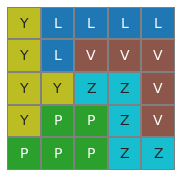

In [204]:
start = time()
holes = np.zeros((5,5),dtype=object)
holes[holes==1] ='.'
holes[holes==0] =' '



i = fill(holes,shape_list)


shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
mapping = np.vectorize(lambda x:shapes.index(x))
shading = mapping(i)
fig,axs = plt.subplots(1,1,figsize =(3,3))
axs = sns.heatmap(shading,annot=i,cbar=False,cmap="tab10",fmt="",linewidths=1,annot_kws={"size":14},linecolor='grey')
axs.axis("off")
print("Took {} seconds".format(time()-start))

<img src="https://www.janestreet.com/puzzles/20181203_pent-up_ans.png" width = 200>

In [189]:
holes= np.array([[1, 0, 1, 0, 1, 1, 0, 1],
                 [0, 0, 0, 0, 1, 1, 0, 0],
                 [1, 0, 1, 0, 0, 0, 0, 1],
                 [0, 0, 0, 1, 0, 1, 0, 1],
                 [1, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0],
                 [1, 0, 0, 0, 1, 0, 1, 1]],dtype=object)


holes[holes==1] ='.'
holes[holes==0] =' '

i = fill(holes,shape_list)
shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
mapping = np.vectorize(lambda x:shapes.index(x))
shading = mapping(i)
fig,axs = plt.subplots(1,1,figsize =(3,3))
axs = sns.heatmap(shading,annot=i,cbar=False,cmap="tab10",fmt="",linewidths=1,annot_kws={"size":14},linecolor='grey')
axs.axis("off")
print("Took {} seconds".format(time()-start))

KeyboardInterrupt: 